In [10]:
import time
import numpy as np
import os
from scipy.io import wavfile

# sklearn
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

# visualization
import matplotlib.pyplot as plt
import seaborn
from tqdm.notebook import tqdm

# torch
import torch
from torchaudio import transforms 
from torch import nn
import torch.nn.functional as F

# Dataset
from torch.utils.data import DataLoader, Dataset

#Sklearn
from sklearn.model_selection import train_test_split

import copy


##### AudioDataset class

In [11]:
sliced_dataset = "../data/short_audio_dataset"
sliced_dataset_lenght = 16050
original_dataset = "../data/audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, drop_both=False):
        root_folder = original_dataset
        max_length = original_dataset_lenght
        self.class_map = {"both": 0, "esben" : 1, "peter": 2}
        self.data = []
        self.wavs = []
        self.labels = []
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if "both" in subdir and drop_both:
                   continue
                file_path = os.path.join(subdir, file_name)
                _, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                if wav.shape[0] > max_length:
                    max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                wav = np.pad(wav, (0, max_length-wav.shape[0]))
                label_str = file_path.split('/')[3][2:]
                label = (np.float32(self.class_map[label_str]))
                self.wavs.append(wav)
                self.labels.append(label)
                self.data.append([wav, label])
        print("Max length of wav files:", max_length)
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        wav = self.wavs[idx]
        class_id = self.labels[idx]
        # class_id = self.class_map[label]
        wav_tensor = torch.from_numpy(wav)
        class_id = torch.tensor([class_id])
        return wav_tensor, class_id


### Data generation

In [12]:
dataset = AudioDataset(drop_both=True)
train_data, val_data, train_labels, val_labels = train_test_split(dataset.data, dataset.labels, test_size=0.2, random_state=42)
train_loader = DataLoader(dataset, batch_size=5, shuffle=True)
valid_loader = DataLoader(dataset, batch_size=5, shuffle=True)
for x, y in train_loader:
    print(x.shape, y.shape)

Max length of wav files: 80249
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
torch.Size([5, 80249]) torch.Size([5, 1])
tor

# MLP
* Build a Multi Layer Perceptron, MLP, with one ReLU-activated hidden layer.
* Use the validation set to inform e.g. number of hidden neurons.
* When you're satisfied, then, use the test set to get an  
unbiased estimate of your models performance on the real data distribution.

In [13]:
# by extending nn.Module:
class MLP(nn.Module):
  def __init__(self, n_hidden_neurons: int):
    super().__init__()
    self.fc1 = nn.Linear(original_dataset_lenght, n_hidden_neurons)
    self.fc2 = nn.Linear(n_hidden_neurons, 2)

  def forward(self, x: torch.Tensor):
    # print(self.fc1.weight, self.fc1.bias, x)
    # print(type(self.fc1.weight), type(self.fc1.bias), type(x))
    # print("here")
    # x = x.flatten(start_dim=0)  # (N, d_data)
    h = F.relu(self.fc1(x))
    logits = self.fc2(h)
    return logits

In [14]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

In [15]:
device = torch.device('cuda')
for n_hidden_neurons in (10, 100, 1000, 10000):
  model = MLP(n_hidden_neurons)
  opt = torch.optim.SGD(model.parameters(), lr=5e-2)

  train_losses, train_accuracies = [], []
  valid_losses, valid_accuracies = [], []

  for epoch in range(50):
    print(epoch, end='\r')
    # train
    epoch_losses = []
    correct, total = 0, 0
    for x, y in train_loader:
      print(x, type(x))
      opt.zero_grad()
      # x, y = torch.tensor(x), torch.tensor(y)
      logits = model(x)  # logits: common name for the output before softmax activation
      log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
      loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
      # or just: loss = F.cross_entropy(logits, y)

      loss.backward()
      opt.step()

      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    train_losses.append(np.mean(epoch_losses))
    train_accuracies.append(correct / total)

  all_losses[n_hidden_neurons] = train_losses, valid_losses
  all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

tensor([[-5.4700e+02, -5.4400e+02, -5.3300e+02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.0000e+00,  3.0000e+00, -8.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.3290e+03,  3.6990e+03,  4.0680e+03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.2100e+02,  5.1100e+02,  2.5000e+01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.9000e+01,  3.3000e+01,  6.9000e+01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]) <class 'torch.Tensor'>


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


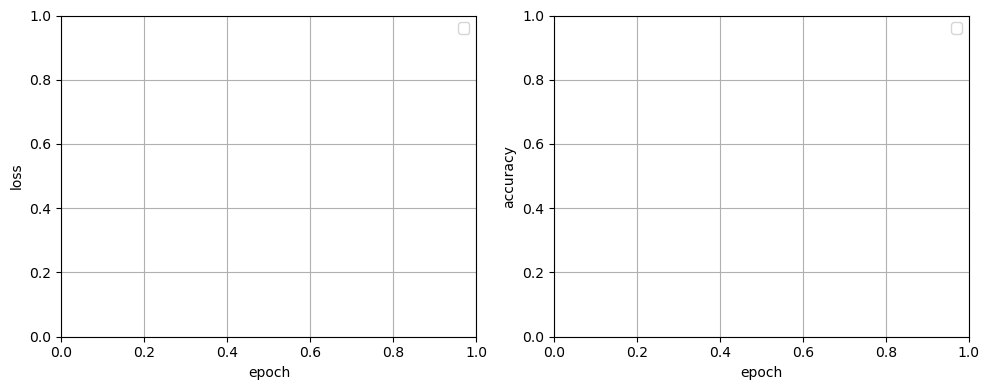

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# test
model, n_hidden_neurons, epoch = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch} epoch')

correct, total = 0, 0
for x, y in valid_loader:
  x, y = x.to(device), y.to(device)
  with torch.no_grad():
    logits = model(x)
  total += len(x)
  correct += (torch.argmax(logits, dim=1) == y).sum().item()
print(f'test accuracy: {correct / total:.2f}')

NameError: name 'best_model' is not defined

### A note on overfitting
You may find different interpretations of what overfitting is, including:

* The gap between training loss and validation loss
* When the validation loss starts rising (around epoch 15-20 above)
* The gap between training accuracy and validation accuracy
* When the validation error (here, 1 - accuracy) starts rising (doesn't really happen here, presumably because we're dealing with small models)

In all cases though, it refers to the model learnings something from the training dataset that doesn't generalize to the validation dataset, and we don't really want that.

In lecture 6, we'll look at how to reduce overfitting.